# Adaptive Model for Conditional Reasoning
I build a model with the following desirada:
* Based on a (published) cognitive model
* Incorporates new data of the individual reasoner

I test properties:
* 4 scoring functions
* Dependence of the score on the weight of the new data

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scoring_rules
import utility
import scipy.optimize
import random
random.seed(123)

### Data input

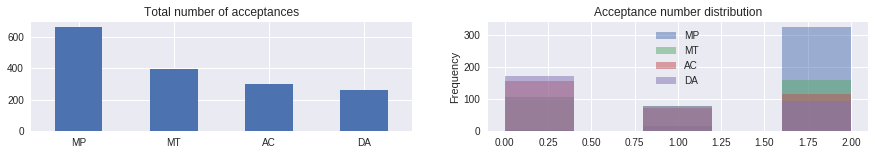

In [2]:
# Read in experimental oberauer data
# It consists of participants' answers to two abstract conditionals
patterns = pd.read_csv('../conditional_data/oberauer_81_patterns.csv')
patterns = patterns.drop(patterns.columns[0], axis=1)

# Transform counts into individual responses
data = []
for pattern in patterns.columns:
    frequency = patterns.loc[0, pattern]
    data += [[int(pattern[i]) for i in range(len(pattern))]] * frequency
data = pd.DataFrame(np.array(data), columns=['MP', 'MT', 'AC', 'DA'])

# Plot data summaries
fig, ax = plt.subplots(1, 2, figsize=(15,2))
data.sum(axis=0).plot(kind='bar', rot=0, ax=ax[0], title='Total number of acceptances')
data.plot(kind='hist', bins=5, alpha=0.5, ax=ax[1], title='Acceptance number distribution')
plt.show()

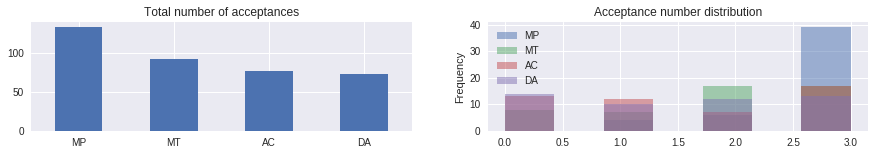

In [3]:
# Read in pre-formatted experimental data from Julia Wertheim's web-experiment
# Data consist of participants' answers to three everyday conditionals with lentils, peas etc.
julia_data = pd.read_csv('data/deduction_individual_responses.csv', sep=',').set_index('token')

fig, ax = plt.subplots(1, 2, figsize=(15,2))
julia_data.sum(axis=0).plot(kind='bar', rot=0, ax=ax[0], title='Total number of acceptances')
julia_data.plot(kind='hist', bins=7, alpha=0.5, ax=ax[1], title='Acceptance number distribution')
plt.show()

### Model imports

In [4]:
#from uniform_model import UniformModel
#from empirical_aggregate_model import EmpiricalAggregate
#from generic_mpt_model import GenericMPT
from chater_oaksford_model import ChaterOaksford
#from independence_model import IndependenceModel
#from dependence_model import DependenceModel
from adaptive_chater_oaksford_model import AdaptiveChaterOaksford
print('importing done.')

importing done.


## Individualistic Evaluation
* Iterate over all participants
    * For every participant, let every model predict the response
    * Save the score the model archieved
    * Then tell the model the actual resonse
* Evaluate the complete prediction-answer set

In [9]:
data.max().max()

2

Dataset: oberauer, answers: 2
Progress: 342 / 343


KeyError: 'oberauer'

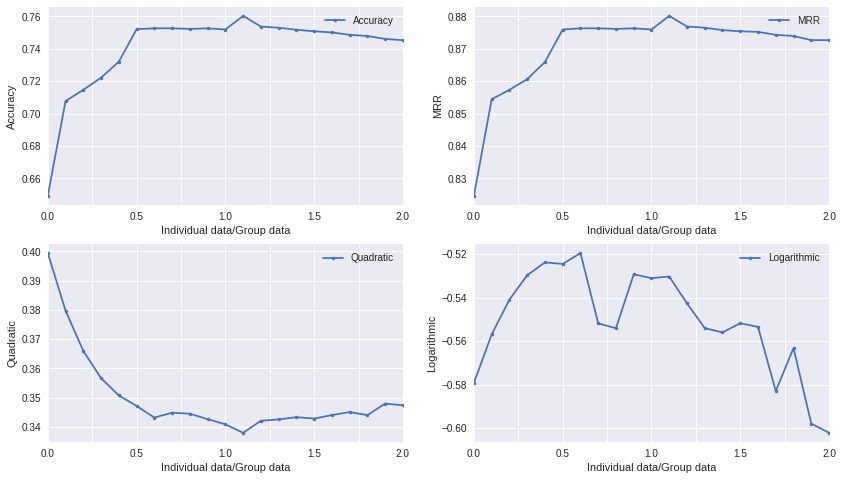

In [21]:
models = []
#models = [UniformModel(), EmpiricalAggregate()]
#models += [DependenceModel(), IndependenceModel(), GenericMPT()]

THIN = 1
STEP = 0.1
MAX  = 2.0 + STEP

adas = [AdaptiveChaterOaksford(model_name=str(i), weight = i) for i in list(np.arange(0, MAX, STEP))]
models += adas
for model in models:
    model.fit(dataset=data)

modi = data.columns

selected_scoring_rules = {'Quadratic': scoring_rules.quad_score, 
                          'Logarithmic': scoring_rules.mean_log_score,                                                 
                          'Accuracy': scoring_rules.mean_accuracy,
                          'MRR': scoring_rules.mrr_score}


modi = list(data.columns)

fig, ax = plt.subplots(2, 2, figsize=(14,8))
legend = []
datasets = {'julia_webxp': julia_data, 'oberauer': data}
for data_name, data_set in datasets.items():
    numeric_scores = pd.DataFrame(0.0, columns=['Accuracy', 'MRR', 'Quadratic', 'Logarithmic'], 
                              index=[model.__name__ for model in models])
    
    print('Dataset: {}, answers: {}'.format(data_name, data_set.max().max()))
    working_data = data_set.copy()

    for row in range(0, data_set.shape[0], THIN):
        random.shuffle(modi)
        # Re-initialize models to remove leftover information
        models = [AdaptiveChaterOaksford(model_name=str(i), weight = i) for i in list(np.arange(0, MAX, STEP))]

        # Fit models to aggregate dataset
        for model in models:
            model.fit(dataset=data_set)

        # Iterate over all four modi MP, MT, AC, DA
        for modus in modi:

            # There are two answers per participant
            for answer_number in range(0, data_set.max().max()):

                # Transform answer frequency to [yes, no]
                truth = np.array([[0, 0]])
                if working_data[modus][row] > 0:
                    truth[0, 0] = 1
                else:
                    truth[0, 1] = 1

                # If the participant gave the same answer twice, remember this
                working_data[modus][row] -= 1

                # Let all models predict the answer
                for model in models:
                    prediction = model.predict(modus)
                    # Transform to format [accept, reject]
                    prediction = np.array([[prediction, 1 - prediction]])

                    # Rate the prediction with all scoring rules
                    for rule_name, scoring_rule in selected_scoring_rules.items():
                        numeric_scores[rule_name][model.__name__] += scoring_rule(np.array(prediction), truth)

                    # tell the model what actually happened
                    model.feedback(problem=modus, answer=truth[0, 0])

        print('Progress: {} / {}'.format(row, data_set.shape[0]), end='\r')
    print()

    # Divide the scores by the number of participants sampled
    numeric_scores /= (data_set.shape[0] / THIN)
    # Divide the scores by the number of answers given per participant (8)
    numeric_scores /= (data_set.max().max() * data_set.shape[1])
    
    i = 0
    for rule_name in numeric_scores.columns:
        axis = ax[i // 2, i % 2]
        a = numeric_scores[rule_name].plot(style='.-', rot=0, ax=axis, legend=True)
        axis.set_xlabel('Individual data/Group data')
        axis.set_ylabel(rule_name)
        i += 1
        legend += [data_name]
    
    for rule_name in numeric_scores[data_name].columns:
        axis.legend(legend);
        #axis.legend(["Oberauer (3 Cond/ 343 Part)", "Julia (3 Cond/ 49 Part)"]);        

### Conclusion
I have done a gridsearch on possible old/new empirical data weighting strategies.
* There seems to be a quasi-optimal value for (*Accuracy, MRR, Quad*) but it is not optimal for *Log*
* This is weird as both Quda and Log are strictly proper scoring rules
* The score-weight landscape is not very smooth, there are spikes